In [1]:
!pip install -q --upgrade transformers diffusers ftfy


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 46.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 934.9/934.9 kB 32.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 63.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 22.5 MB/s eta 0:00:00


In [2]:
from base64 import b64encode

import numpy
import torch
from diffusers import AutoencoderKL, LMSDiscreteScheduler, UNet2DConditionModel
from huggingface_hub import notebook_login

# For video display:
from IPython.display import HTML
from matplotlib import pyplot as plt
from pathlib import Path
from PIL import Image
from torch import autocast
from torchvision import transforms as tfms
from tqdm.auto import tqdm
from transformers import CLIPTextModel, CLIPTokenizer, logging

torch.manual_seed(1)
if not (Path.home()/'.huggingface'/'token').exists(): notebook_login()

# Supress some unnecessary warnings when loading the CLIPTextModel
logging.set_verbosity_error()

# Set device
torch_device = "cuda" if torch.cuda.is_available() else "cpu"

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [3]:
# Load the autoencoder model which will be used to decode the latents into image space. 
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae" ,torch_dtype=torch.float16)

# Load the tokenizer and text encoder to tokenize and encode the text. 
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14",torch_dtype=torch.float16)
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14",torch_dtype=torch.float16)

# The UNet model for generating the latents.
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet", torch_dtype=torch.float16)

# The noise scheduler
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)

# To the GPU we go!
vae = vae.to(torch_device)
text_encoder = text_encoder.to(torch_device)
unet = unet.to(torch_device);

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


In [4]:
def pil_to_latent(input_im):
    # Single image -> single latent in a batch (so size 1, 4, 64, 64)
    with torch.no_grad():
        latent = vae.encode(tfms.ToTensor()(input_im).unsqueeze(0).to(torch_device)*2-1) # Note scaling
    return 0.18215 * latent.latent_dist.sample()

def latents_to_pil(latents):
    # bath of latents -> list of images
    latents = (1 / 0.18215) * latents
    with torch.autocast("cuda"):
      with torch.no_grad():
          image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]
    return pil_images

In [5]:
# Our text prompt
prompt = 'A picture of a lion'
# Turn the text into a sequnce of tokens:
text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
print(text_input['input_ids'][0]) # View the tokens
# See the individual tokens
for t in text_input['input_ids'][0][:8]: # We'll just look at the first 7 to save you from a wall of '<|endoftext|>'
    print(t, tokenizer.decoder.get(int(t)))
# Grab the output embeddings
output_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]
print('Shape:', output_embeddings.shape)
output_embeddings
# Access the embedding layer
token_emb_layer = text_encoder.text_model.embeddings.token_embedding
token_emb_layer # 
# Embed a token - in this case the one for 'puppy'
embedding = token_emb_layer(torch.tensor(5567, device=torch_device))
embedding.shape # 768-dim representation
token_embeddings = token_emb_layer(text_input.input_ids.to(torch_device))
print(token_embeddings.shape) # batch size 1, 77 tokens, 768 values for each
token_embeddings
pos_emb_layer = text_encoder.text_model.embeddings.position_embedding
pos_emb_layer
position_ids = text_encoder.text_model.embeddings.position_ids[:, :77]
position_embeddings = pos_emb_layer(position_ids)
print(position_embeddings.shape)
position_embeddings
# And combining them we get the final input embeddings
input_embeddings = token_embeddings + position_embeddings
print(input_embeddings.shape)
input_embeddings
# The following combines all the above steps (but doesn't let us fiddle with them!)
text_encoder.text_model.embeddings(text_input.input_ids.to(torch_device))

tensor([49406,   320,  1674,   539,   320,  5567, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407])
tensor(49406) <|startoftext|>
tensor(320) a</w>
tensor(1674) picture</w>
tensor(539) of</w>
tensor(320) a</w>
tensor(5567) lion</w>
tensor(49407) <|endoftext|>
tensor(49407) <|endoftext|>
Shape: torch.Size([1, 77, 768])
torch.Size([1, 77, 768])
torch.Size([1, 77, 768])
torch.Size([1, 77, 768])


tensor([[[ 2.6779e-03,  5.2109e-03,  4.9305e-04,  ..., -3.1319e-03,
           1.0662e-03,  3.4313e-03],
         [ 5.5389e-03,  1.7509e-03, -1.2383e-02,  ..., -1.1414e-02,
           1.3504e-02,  6.8359e-03],
         [ 2.5345e-02, -1.1017e-02,  9.7656e-03,  ...,  1.9455e-03,
           6.8398e-03,  1.8585e-02],
         ...,
         [ 2.2781e-02,  1.3260e-02, -1.1238e-02,  ..., -8.0032e-03,
          -2.0561e-03,  8.9340e-03],
         [ 2.0020e-02,  1.5015e-02, -8.7662e-03,  ..., -4.0321e-03,
           1.8597e-05,  1.0880e-02],
         [ 3.4180e-02,  3.5828e-02,  2.7771e-02,  ...,  1.4465e-02,
           1.1108e-02, -2.5757e-02]]], device='cuda:0', dtype=torch.float16,
       grad_fn=<AddBackward0>)

In [6]:
def get_output_embeds(input_embeddings):
    # CLIP's text model uses causal mask, so we prepare it here:
    bsz, seq_len = input_embeddings.shape[:2]
    causal_attention_mask = text_encoder.text_model._build_causal_attention_mask(bsz, seq_len, dtype=input_embeddings.dtype)

    # Getting the output embeddings involves calling the model with passing output_hidden_states=True 
    # so that it doesn't just return the pooled final predictions:
    encoder_outputs = text_encoder.text_model.encoder(
        inputs_embeds=input_embeddings,
        attention_mask=None, # We aren't using an attention mask so that can be None
        causal_attention_mask=causal_attention_mask.to(torch_device),
        output_attentions=None,
        output_hidden_states=True, # We want the output embs not the final output
        return_dict=None,
    )

    # We're interested in the output hidden state only
    output = encoder_outputs[0]

    # There is a final layer norm we need to pass these through
    output = text_encoder.text_model.final_layer_norm(output)

    # And now they're ready!
    return output

out_embs_test = get_output_embeds(input_embeddings) # Feed through the model with our new function
print(out_embs_test.shape) # Check the output shape
out_embs_test # Inspect the output

torch.Size([1, 77, 768])


tensor([[[-0.3884,  0.0229, -0.0523,  ..., -0.4902, -0.3066,  0.0674],
         [ 0.0292, -1.3242,  0.3076,  ..., -0.5254,  0.9766,  0.6655],
         [ 0.6968,  0.3535,  1.0977,  ..., -1.5742, -1.2656, -0.0118],
         ...,
         [-1.2910,  0.9321,  0.0840,  ..., -0.7891, -0.0238, -0.1477],
         [-1.2891,  0.9292,  0.0956,  ..., -0.7861, -0.0261, -0.1484],
         [-1.3145,  0.9590,  0.1071,  ..., -0.8105,  0.0047, -0.1323]]],
       device='cuda:0', dtype=torch.float16, grad_fn=<NativeLayerNormBackward0>)

In [7]:
def generate_with_embs(text_embeddings):
    height = 512                        # default height of Stable Diffusion
    width = 512                         # default width of Stable Diffusion
    num_inference_steps = 30            # Number of denoising steps
    guidance_scale = 7.5                # Scale for classifier-free guidance
    generator = torch.manual_seed(32)   # Seed generator to create the inital latent noise
    batch_size = 1

    max_length = text_input.input_ids.shape[-1]
    uncond_input = tokenizer(
      [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
    )
    with torch.no_grad():
        uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0] 
    text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

    # Prep Scheduler
    scheduler.set_timesteps(num_inference_steps)

    # Prep latents
    latents = torch.randn(
    (batch_size, unet.in_channels, height // 8, width // 8),
    generator=generator,
    )
    latents = latents.to(torch_device)
    latents = latents * scheduler.init_noise_sigma

    # Loop
    for i, t in tqdm(enumerate(scheduler.timesteps)):
        # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
        latent_model_input = torch.cat([latents] * 2)
        sigma = scheduler.sigmas[i]
        latent_model_input = scheduler.scale_model_input(latent_model_input, t)

        # predict the noise residual
        with torch.autocast("cuda"): 
          with torch.no_grad():
              noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

        # perform guidance
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        # compute the previous noisy sample x_t -> x_t-1
        latents = scheduler.step(noise_pred, t, latents).prev_sample

    return latents_to_pil(latents)[0]


In [8]:
styles = []
learned_embed = {}
for i in [2,3,4,5,6]:
  learned_embed[i] = torch.load("learned_embeds ("+str(i)+").bin")
for i, j in learned_embed.items():
  for key in j.keys():
    styles.append(str(key))


In [9]:
saved_embed={}
styled_images = {}
for index,text in enumerate(styles):
  print(index)
  prompt = 'A horse in the style of lion'

  # Tokenize
  text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
  input_ids = text_input.input_ids.to(torch_device)

  # Get token embeddings
  token_embeddings = token_emb_layer(input_ids)

  # The new embedding - our special birb word
  replacement_token_embedding = learned_embed[index+2][text].to(torch_device)
  replacement_token_embedding = replacement_token_embedding.to(token_embeddings.dtype)
  # Insert this into the token embeddings
  token_embeddings[0, torch.where(input_ids[0]==5567)] = replacement_token_embedding.to(torch_device)

  # Combine with pos embs
  input_embeddings = token_embeddings + position_embeddings

  #  Feed through to get final output embs
  modified_output_embeddings = get_output_embeds(input_embeddings)

  # And generate an image with this:
  styled_images[text] = generate_with_embs(modified_output_embeddings)
  saved_embed[text]=modified_output_embeddings

0


<ipython-input-7-32a54cf06c64>:22: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


0it [00:00, ?it/s]

1


0it [00:00, ?it/s]

2


0it [00:00, ?it/s]

3


0it [00:00, ?it/s]

4


0it [00:00, ?it/s]

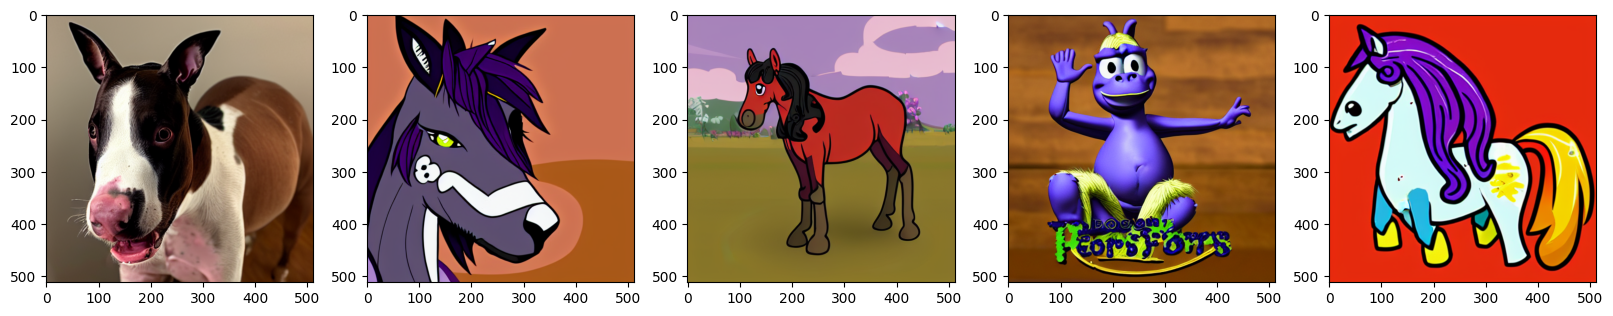

In [10]:
plt.figure(figsize=(20,10))
columns = 5
for i, image in enumerate(styled_images.values()):
    plt.subplot(int(len(styled_images.values()) / columns + 1), columns, i + 1)
    plt.imshow(image)

In [11]:
canny_edges_images = []
#denoised_images
import cv2
from google.colab.patches import cv2_imshow
for name, image in styled_images.items():
    # How far are the blue channel values to 0.9:
  img = numpy.array(image)
  img=numpy.float64(img)
  #img =numpy.transpose(img,(1,2,0))
  #img = cv2.imread("b-e-e4.png")  # Read image
    
  # Setting parameter values
  t_lower = 50  # Lower Threshold
  t_upper = 150  # Upper threshold
    
  # Applying the Canny Edge filter
  edge = cv2.Canny(numpy.uint8(img), t_lower, t_upper)
  #cv2_imshow(edge)
  PIL_image = Image.fromarray(numpy.uint8(edge)).convert('RGB')
  PIL_image.save(name+".png")
  canny_edges_images.append(PIL_image)




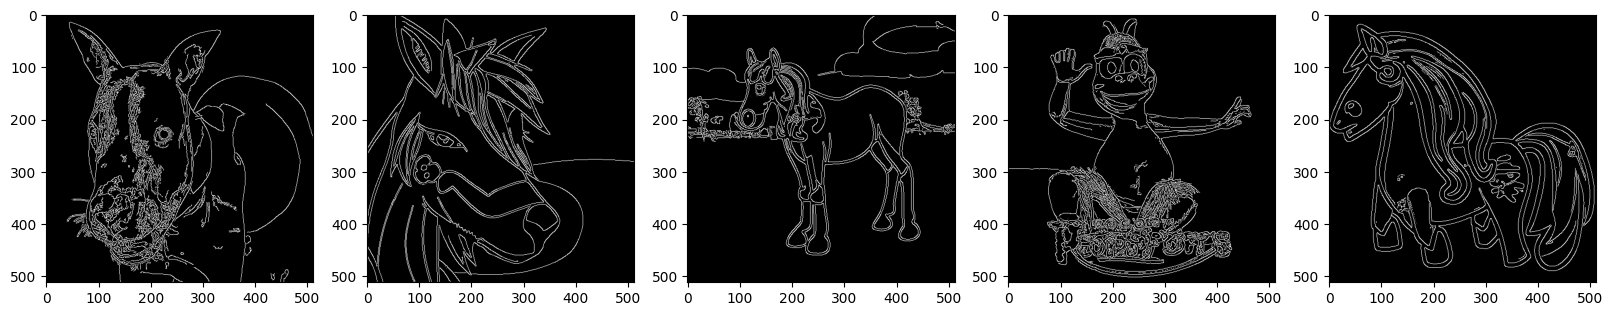

In [12]:
plt.figure(figsize=(20,10))
columns = 5
for i,image in enumerate(canny_edges_images):
    plt.subplot(int(len(canny_edges_images) / columns + 1), columns, i + 1)
    plt.imshow(image)
    #print(imag)

In [13]:
import torchvision
loader=torchvision.transforms.Compose([torchvision.transforms.Resize((512,512)),torchvision.transforms.ToTensor()])

In [14]:

def blue_loss(images,edge):
    #print(images.shape, edge.shape)
    error = torch.abs(images- edge).mean()
    return error

In [15]:
final_images = []
for name in styled_images.keys():
  print("\n--------------------Training For " + name + "style----------------------")
  style = Image.open(name+".png")
  style=loader(style).unsqueeze(0)
  edge = style.to(torch.float16).to(torch_device)
  prompt = 'A horse in the style of lion'
  height = 512                        # default height of Stable Diffusion
  width = 512                         # default width of Stable Diffusion
  num_inference_steps = 50            # Number of denoising steps
  guidance_scale = 8               # Scale for classifier-free guidance
  generator = torch.manual_seed(32)   # Seed generator to create the inital latent noise
  batch_size = 1
  blue_loss_scale = 35

  # Prep text 
  text_input = tokenizer([prompt], padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
  text_embeddings = saved_embed[name]
  #print(text_embeddings.shape)

  # And the uncond. input as before:
  max_length = text_input.input_ids.shape[-1]
  uncond_input = tokenizer(
      [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
  )
  with torch.no_grad():
      uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0] 
  text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

  # Prep Scheduler
  scheduler.set_timesteps(num_inference_steps)

  # Prep latents
  latents = torch.randn(
    (batch_size, unet.in_channels, height // 8, width // 8),
    generator=generator,
  )
  latents = latents.to(torch_device)
  latents = latents * scheduler.init_noise_sigma

  # Loop
  for i, t in tqdm(enumerate(scheduler.timesteps)):
      # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
      latent_model_input = torch.cat([latents] * 2)
      sigma = scheduler.sigmas[i]
      latent_model_input = scheduler.scale_model_input(latent_model_input, t)

      
      # predict the noise residual
      with torch.autocast("cuda"):
        with torch.no_grad():
            noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

      # perform CFG
      noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
      noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)
      
      #### ADDITIONAL GUIDANCE ###
      #if i%5 == 0:
      # Requires grad on the latents
      latents = latents.detach().requires_grad_()

      # Get the predicted x0:
      # latents_x0 = latents - sigma * noise_pred
      latents_x0 = scheduler.step(noise_pred, t, latents).pred_original_sample

      with torch.autocast("cuda"):
      # Decode to image space
        denoised_images = vae.decode((1 / 0.18215) * latents_x0).sample / 2 + 0.5 # range (0, 1)

      # Calculate loss
      loss = blue_loss(denoised_images, edge) * blue_loss_scale
      
      # Occasionally print it out
      #if i%10==0:
      print(i, 'loss:', loss.item(), end="  ")

      # Get gradient
      cond_grad = torch.autograd.grad(loss, latents)[0]

      # Modify the latents based on this gradient
      latents = latents.detach() - cond_grad * sigma**2
      
      # Now step with scheduler
      latents = scheduler.step(noise_pred, t, latents).prev_sample


  final_images.append(latents_to_pil(latents)[0])



--------------------Training For <cat-toy>style----------------------


<ipython-input-15-8f03b285b9e2>:35: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


0it [00:00, ?it/s]

0 loss: 15.125  1 loss: 11.1015625  2 loss: 10.0390625  3 loss: 9.984375  4 loss: 9.96875  5 loss: 10.0625  6 loss: 10.0859375  7 loss: 10.3671875  8 loss: 9.2109375  9 loss: 8.2265625  10 loss: 8.1015625  11 loss: 7.94140625  12 loss: 7.7265625  13 loss: 7.703125  14 loss: 7.73046875  15 loss: 7.74609375  16 loss: 7.75390625  17 loss: 7.7578125  18 loss: 7.765625  19 loss: 7.7890625  20 loss: 7.80859375  21 loss: 7.80078125  22 loss: 7.80859375  23 loss: 7.83203125  24 loss: 7.8515625  25 loss: 7.87890625  26 loss: 7.8984375  27 loss: 7.859375  28 loss: 7.85546875  29 loss: 7.85546875  30 loss: 7.859375  31 loss: 7.859375  32 loss: 7.8671875  33 loss: 7.87109375  34 loss: 7.87109375  35 loss: 7.875  36 loss: 7.875  37 loss: 7.87890625  38 loss: 7.87890625  39 loss: 7.8828125  40 loss: 7.88671875  41 loss: 7.88671875  42 loss: 7.88671875  43 loss: 7.890625  44 loss: 7.890625  45 loss: 7.890625  46 loss: 7.890625  47 loss: 7.88671875  48 loss: 7.88671875  49 loss: 7.890625  
-----------

0it [00:00, ?it/s]

0 loss: 14.0  1 loss: 8.140625  2 loss: 6.6015625  3 loss: 6.53125  4 loss: 8.8203125  5 loss: 9.515625  6 loss: 8.453125  7 loss: 8.328125  8 loss: 8.484375  9 loss: 8.421875  10 loss: 8.3359375  11 loss: 7.73828125  12 loss: 7.64453125  13 loss: 7.578125  14 loss: 7.58203125  15 loss: 7.64453125  16 loss: 7.73046875  17 loss: 7.69921875  18 loss: 7.5234375  19 loss: 7.375  20 loss: 7.3125  21 loss: 7.1953125  22 loss: 7.1171875  23 loss: 7.0625  24 loss: 7.01953125  25 loss: 7.0078125  26 loss: 6.984375  27 loss: 6.95703125  28 loss: 6.92578125  29 loss: 6.90625  30 loss: 6.89453125  31 loss: 6.88671875  32 loss: 6.87890625  33 loss: 6.875  34 loss: 6.84765625  35 loss: 6.83984375  36 loss: 6.83203125  37 loss: 6.82421875  38 loss: 6.8203125  39 loss: 6.81640625  40 loss: 6.81640625  41 loss: 6.80859375  42 loss: 6.80859375  43 loss: 6.80859375  44 loss: 6.81640625  45 loss: 6.81640625  46 loss: 6.8203125  47 loss: 6.8203125  48 loss: 6.8203125  49 loss: 6.81640625  
----------------

0it [00:00, ?it/s]

0 loss: 20.1875  1 loss: 15.8046875  2 loss: 13.9609375  3 loss: 13.421875  4 loss: 12.765625  5 loss: 10.9765625  6 loss: 9.9296875  7 loss: 9.4765625  8 loss: 9.203125  9 loss: 8.859375  10 loss: 8.7265625  11 loss: 8.90625  12 loss: 8.6015625  13 loss: 7.88671875  14 loss: 8.3046875  15 loss: 8.6328125  16 loss: 8.265625  17 loss: 7.7890625  18 loss: 7.71484375  19 loss: 7.25390625  20 loss: 7.09375  21 loss: 7.21484375  22 loss: 7.7265625  23 loss: 6.96875  24 loss: 6.96875  25 loss: 6.95703125  26 loss: 6.88671875  27 loss: 6.82421875  28 loss: 6.83203125  29 loss: 6.8515625  30 loss: 6.80859375  31 loss: 6.7421875  32 loss: 6.734375  33 loss: 6.73828125  34 loss: 6.73828125  35 loss: 6.71484375  36 loss: 6.7109375  37 loss: 6.703125  38 loss: 6.69140625  39 loss: 6.671875  40 loss: 6.65234375  41 loss: 6.640625  42 loss: 6.625  43 loss: 6.61328125  44 loss: 6.60546875  45 loss: 6.6015625  46 loss: 6.59375  47 loss: 6.58984375  48 loss: 6.58203125  49 loss: 6.60546875  
----------

0it [00:00, ?it/s]

0 loss: 11.5  1 loss: 7.59765625  2 loss: 7.27734375  3 loss: 6.58984375  4 loss: 5.57421875  5 loss: 8.1171875  6 loss: 6.515625  7 loss: 6.03125  8 loss: 5.86328125  9 loss: 5.7578125  10 loss: 5.74609375  11 loss: 5.76171875  12 loss: 5.86328125  13 loss: 5.984375  14 loss: 6.03125  15 loss: 6.10546875  16 loss: 6.26953125  17 loss: 6.37890625  18 loss: 6.46484375  19 loss: 6.4765625  20 loss: 6.43359375  21 loss: 6.53515625  22 loss: 6.53515625  23 loss: 6.625  24 loss: 6.87890625  25 loss: 6.88671875  26 loss: 6.5546875  27 loss: 6.44140625  28 loss: 6.3515625  29 loss: 6.30859375  30 loss: 6.296875  31 loss: 6.28515625  32 loss: 6.26953125  33 loss: 6.25  34 loss: 6.23046875  35 loss: 6.20703125  36 loss: 6.19140625  37 loss: 6.1796875  38 loss: 6.171875  39 loss: 6.1640625  40 loss: 6.16015625  41 loss: 6.15625  42 loss: 6.15234375  43 loss: 6.1484375  44 loss: 6.1484375  45 loss: 6.1484375  46 loss: 6.14453125  47 loss: 6.1484375  48 loss: 6.1484375  49 loss: 6.14453125  
-----

0it [00:00, ?it/s]

0 loss: 17.625  1 loss: 15.3671875  2 loss: 14.1953125  3 loss: 12.671875  4 loss: 11.421875  5 loss: 11.09375  6 loss: 10.9375  7 loss: 11.4609375  8 loss: 11.8671875  9 loss: 10.4296875  10 loss: 10.3671875  11 loss: 9.6640625  12 loss: 9.3203125  13 loss: 9.5703125  14 loss: 9.90625  15 loss: 9.6875  16 loss: 9.6484375  17 loss: 9.9609375  18 loss: 9.484375  19 loss: 9.0234375  20 loss: 8.921875  21 loss: 8.8125  22 loss: 8.7734375  23 loss: 8.7421875  24 loss: 8.75  25 loss: 8.734375  26 loss: 8.7265625  27 loss: 8.7265625  28 loss: 8.734375  29 loss: 8.734375  30 loss: 8.734375  31 loss: 8.7421875  32 loss: 8.734375  33 loss: 8.734375  34 loss: 8.734375  35 loss: 8.7265625  36 loss: 8.7265625  37 loss: 8.734375  38 loss: 8.734375  39 loss: 8.734375  40 loss: 8.734375  41 loss: 8.734375  42 loss: 8.734375  43 loss: 8.734375  44 loss: 8.734375  45 loss: 8.734375  46 loss: 8.7421875  47 loss: 8.7421875  48 loss: 8.7421875  49 loss: 8.734375  

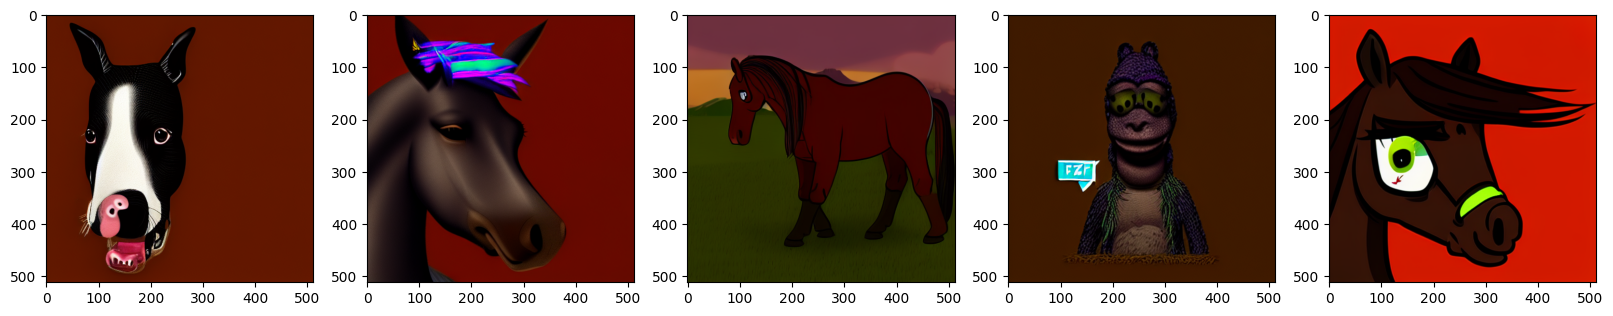

In [18]:
plt.figure(figsize=(20,10))
columns = 5
for i,image in enumerate(final_images):
    plt.subplot(int(len(final_images) / columns + 1), columns, i + 1)
    plt.imshow(image)
    #print(imag)